# Regression

In [ ]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

In [2]:
train_data.shape

(404, 13)

In [9]:
len(train_data)

404

In [3]:
test_data.shape

(102, 13)

 Другим распространенным типом задач машинного обучения является регрессия, которая заключается в предсказании не дискретной метки, а значения на непрерывной числовой прямой: например, предсказание температуры воздуха на завтра по имеющимся метеорологическим данным или предсказание времени завершения программного проекта по его спецификациям

# ПРИМЕЧАНИЕ 
Не путайте регрессию с алгоритмом логистической регрессии. Как ни странно, логистическая регрессия не является регрессионным алгоритмом — это алгоритм классификации.

In [5]:
train_targets

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4, 12.1,
       17.9, 23.1, 19.9, 15.7,  8.8, 50. , 22.5, 24.1, 27.5, 10.9, 30.8,
       32.9, 24. , 18.5, 13.3, 22.9, 34.7, 16.6, 17.5, 22.3, 16.1, 14.9,
       23.1, 34.9, 25. , 13.9, 13.1, 20.4, 20. , 15.2, 24.7, 22.2, 16.7,
       12.7, 15.6, 18.4, 21. , 30.1, 15.1, 18.7,  9.6, 31.5, 24.8, 19.1,
       22. , 14.5, 11. , 32. , 29.4, 20.3, 24.4, 14.6, 19.5, 14.1, 14.3,
       15.6, 10.5,  6.3, 19.3, 19.3, 13.4, 36.4, 17.8, 13.5, 16.5,  8.3,
       14.3, 16. , 13.4, 28.6, 43.5, 20.2, 22. , 23. , 20.7, 12.5, 48.5,
       14.6, 13.4, 23.7, 50. , 21.7, 39.8, 38.7, 22.2, 34.9, 22.5, 31.1,
       28.7, 46. , 41.7, 21. , 26.6, 15. , 24.4, 13.3, 21.2, 11.7, 21.7,
       19.4, 50. , 22.8, 19.7, 24.7, 36.2, 14.2, 18.9, 18.3, 20.6, 24.6,
       18.2,  8.7, 44. , 10.4, 13.2, 21.2, 37. , 30.7, 22.9, 20. , 19.3,
       31.7, 32. , 23.1, 18.8, 10.9, 50. , 19.6,  5. , 14.4, 19.8, 13.8,
       19.6, 23.9, 24.5, 25. , 19.9, 17.2, 24.6, 13

In [76]:
mean= train_data.mean(axis = 0)
train_data -= mean
std = train_data.std(axis = 0)

train_data /= std

test_data -= mean
test_data /= std

In [80]:
train_data.shape[1]

13

In [88]:
from keras import models
from keras import layers

def build_model():    
    model = models.Sequential()     
    model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))    
    model.add(layers.Dense(64, activation='relu'))    
    model.add(layers.Dense(1))    
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])    
    return model

Лучшей практикой в таких ситуациях является применение перекрестной проверки по K блокам (K-fold cross-validation), как показано на рис. 3.11. Суть ее заключается в разделении доступных данных на K блоков (обычно K = 4 или 5), создании K идентичных моделей и обучении каждой на K—1 блоках с оценкой по оставшимся блокам. По полученным K оценкам вычисляется среднее значение, которое принимается как оценка модели. В коде такая проверка реализуется достаточно просто

In [124]:
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []

for i in range(k):
    print('processing fold #', i)
    
    val_data = train_data[i * num_val_samples: (i+1) * num_val_samples]
    val_targets = train_targets[i*num_val_samples: (i+1) * num_val_samples]
    
    partial_train_data = np.concatenate([train_data[:i*num_val_samples],
                                        train_data[(i+1)*num_val_samples:]],
                                       axis = 0)
    partial_train_targets = np.concatenate([train_targets[:i*num_val_samples],
                                           train_targets[(i+1) * num_val_samples:]],
                                          axis = 0)
    model = build_model()
    
    model.fit(partial_train_data, partial_train_targets,
             epochs = num_epochs, batch_size = 1, verbose = 0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose = 0)
    all_scores.append(val_mae)
    

processing fold # 0


KeyError: 'val_mean_absolute_error'

In [110]:
all_scores

[1.9522124528884888, 2.3530242443084717, 2.9154117107391357, 2.360508918762207]

In [111]:
np.mean(all_scores)

2.395289331674576

Разные прогоны действительно показывают разные оценки, от 2,6 до 3,2. Средняя (3,0) выглядит более достоверно, чем любая из оценок отдельных прогонов, — в этом главная ценность перекрестной проверки по K блокам. В данном случае средняя ошибка составила 3000 долларов, что довольно много, если вспомнить, что цены колеблются в диапазоне от 10 000 до 50 000 долларов. Попробуем увеличить время обучения сети до 500 эпох. Чтобы получить информацию о качестве обучения модели в каждую эпоху, изменим цикл обучения и добавим сохранение оценки проверки перед началом эпохи.


In [127]:
#Сохранение оценки проверки перед каждым прогоном

k = 4
num_val_samples = len(train_data) // k

num_epochs = 500

all_mae_histories = []

for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i*num_val_samples: (i+1) * num_val_samples]
    val_targets = train_targets[i*num_val_samples: (i+1) *num_val_samples]
    
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i+1)*num_val_samples:]],
        axis = 0)
    
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i+1) * num_val_samples:]],
        axis = 0)
    
    model = build_model()
    
    history = model.fit(partial_train_data, partial_train_targets,
                       validation_data = (val_data, val_targets),
                       epochs = num_epochs, batch_size = 1, verbose = 0)
    mae_history = history.history['mae']
    all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [139]:
all_mae_histories[0]

[11.312815,
 3.8437424,
 3.246712,
 2.8717542,
 2.633979,
 2.6165278,
 2.571675,
 2.3940365,
 2.3776598,
 2.346719,
 2.2553885,
 2.225827,
 2.2155895,
 2.179921,
 2.07341,
 2.1403832,
 2.0999386,
 2.0507119,
 2.053448,
 2.0530994,
 2.0262911,
 1.9777683,
 1.971138,
 1.8966342,
 1.9096072,
 1.9635243,
 1.9140748,
 1.8294188,
 1.8598694,
 1.8849971,
 1.7998657,
 1.7959741,
 1.8175262,
 1.7872846,
 1.7300673,
 1.7828482,
 1.7372501,
 1.7004687,
 1.7455682,
 1.6816461,
 1.6882806,
 1.715695,
 1.7044011,
 1.7114941,
 1.670178,
 1.6287165,
 1.7102168,
 1.6593974,
 1.7073355,
 1.6508452,
 1.6436036,
 1.5604099,
 1.6142471,
 1.6228108,
 1.599174,
 1.6068492,
 1.5573617,
 1.5544982,
 1.5828443,
 1.6143429,
 1.5812256,
 1.4771515,
 1.5264266,
 1.5059351,
 1.5475831,
 1.5495795,
 1.5478125,
 1.4916259,
 1.5560229,
 1.4955604,
 1.5462657,
 1.449087,
 1.5666454,
 1.4731988,
 1.4637578,
 1.4956404,
 1.5004377,
 1.5093205,
 1.3939046,
 1.4794353,
 1.4650251,
 1.4848094,
 1.4602615,
 1.4029675,
 1.382

In [136]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

In [142]:
np.mean(-12.5)

-12.5

In [140]:
average_mae_history

[11.045235,
 3.7816477,
 3.1254508,
 2.8069408,
 2.6363575,
 2.5218172,
 2.4056096,
 2.344143,
 2.2993617,
 2.2398527,
 2.2175784,
 2.1862648,
 2.1231675,
 2.106949,
 2.0675597,
 2.078276,
 2.016099,
 1.9904386,
 2.0046227,
 1.9836042,
 1.9576693,
 1.9388317,
 1.9192345,
 1.8964895,
 1.8835063,
 1.9018074,
 1.8607581,
 1.8547478,
 1.8394845,
 1.8258593,
 1.7948902,
 1.8012459,
 1.77226,
 1.760279,
 1.7505774,
 1.7533722,
 1.700628,
 1.6825535,
 1.7113675,
 1.6813166,
 1.6705244,
 1.7021792,
 1.6932768,
 1.6394144,
 1.6398392,
 1.6367466,
 1.6265846,
 1.5958034,
 1.6390638,
 1.6064968,
 1.606307,
 1.5579063,
 1.5522778,
 1.5714449,
 1.5558007,
 1.5756601,
 1.5359626,
 1.5201805,
 1.5387714,
 1.514673,
 1.5367395,
 1.4818071,
 1.5196531,
 1.4706671,
 1.4921002,
 1.4834043,
 1.4654942,
 1.4661944,
 1.4770164,
 1.4761044,
 1.4599752,
 1.428416,
 1.448905,
 1.4231164,
 1.394279,
 1.4025396,
 1.3925333,
 1.4049691,
 1.3893877,
 1.3906966,
 1.3900166,
 1.3441652,
 1.3675375,
 1.3377049,
 1.33

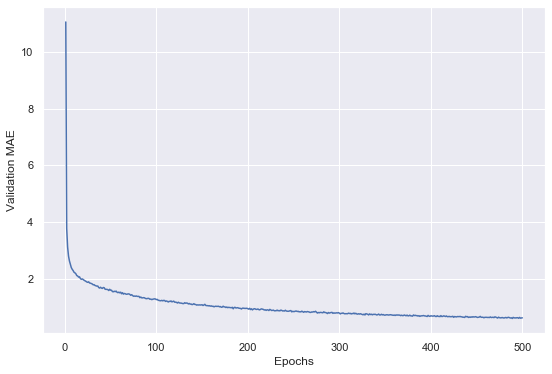

In [153]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc = {'figure.figsize' : (9,6)})

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)

In [154]:
results = model.evaluate(test_data, test_targets)

102/102 [==============================] - 0s 78us/step


In [163]:
#Формирование графика с оценками проверок за исключением первых 10 замеров

def smooth_curve(points, factor = 0.9):
    smoothed_points = []
    
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor+ point * (1-factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

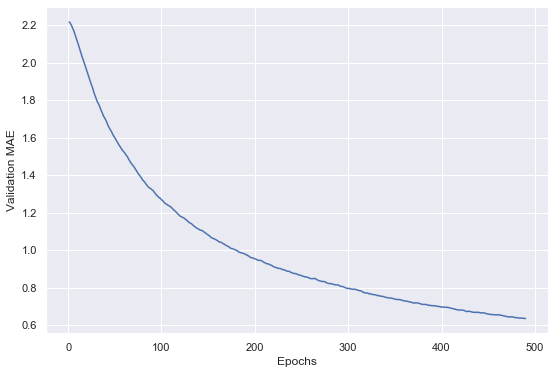

In [164]:
smooth_mae_hist = smooth_curve(average_mae_history[10:])
plt.plot(range(1,len(smooth_mae_hist) + 1), smooth_mae_hist)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [165]:
model = build_model()

model.fit(train_data, train_targets, epochs = 80, batch_size = 16, verbose = 0)

test_mse_score,test_mae_score = model.evaluate(test_data, test_targets)

102/102 [==============================] - 0s 674us/step


In [168]:
test_mse_score

21.83054486443015